# Programming for Chemistry 2025/2026 @ UniMI

![logo](logo_small.png "Logo")

## Lecture 17: DFT calculators
Let's use **Quantum Espresso** and **SIESTA** to calculate the energy curve of a gold nanowire

In [4]:
import ase
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# import from ASE
from ase import Atoms, Atom
from ase.visualize import view

# to access environment variables
import os

In [5]:
# let's create a mono-atomic Au wire (since it is periodic, you need only one atom)
def make_wire(spacing=2.5, box_size=10.0):
    return ase.Atoms('Au',
                     positions=[[0., box_size/2, box_size/2]],
                     cell=[spacing, box_size, box_size],
                     pbc=True)

## 1. Quantum Espresso

In [6]:
# import the Quantum Espresso calculator
os.environ['ASE_ESPRESSO_COMMAND'] = 'mpirun -np 4 /home/ceresoli/Codes/qe-7.4/bin/pw.x -in PREFIX.pwi >PREFIX.pwo'
os.environ['ESPRESSO_PSEUDO'] = '/home/ceresoli/Work/Pseudo-GBRV'
os.environ['ESPRESSO_TMPDIR'] = '/tmp/ceresoli'

from ase.calculators.espresso import Espresso

pseudo = {'Au': 'au_pbe_v1.uspp.F.UPF'}
espresso = Espresso(pseudopotentials=pseudo, kpts=[5,1,1],
                    calculation='scf',
                    ecutwfc=35, ecutrho=350,
                    occupations='smearing', degauss=0.005,
                    mixing_beta=0.1, conv_thr=1e-8)

In [7]:
# let's stretch the wire and compute the potential energy as a function of strain
# for this purpose we'll use numpy.linspace, fit to a polynomial, then plot the result with matplotlib
d = np.linspace(2.0, 3.0, 11)
qe_energy = np.zeros_like(d)

for i in range(len(d)):
    wire = make_wire(spacing=d[i])
    wire.calc = espresso
    qe_energy[i] = wire.get_potential_energy()
    print(d[i], qe_energy[i])

2.0 -1559.2030098842265
2.1 -1560.960163500352
2.2 -1562.0168434417503
2.3 -1562.6181957050967
2.4 -1562.925518761507
2.5 -1563.0443078808612
2.6 -1563.0450489829009
2.7 -1562.9748912324494
2.8 -1562.87543144751
2.9 -1562.766910952028
3.0 -1562.650998075948


In [8]:
# fit polynominal, calculate first derivative, find the zero
poly = np.polyfit(d, qe_energy, deg=4)
dpoly = np.polyder(poly, 1)

dopt = 0.0
for root in np.roots(dpoly):
    if abs(root.imag) < 1e-10 and 2.0 < root.real < 3.0:
        dopt = root.real
        
print(f'optimal d = {dopt:.4} Å')
qe_eopt = np.polyval(poly, dopt)

optimal d = 2.533 Å


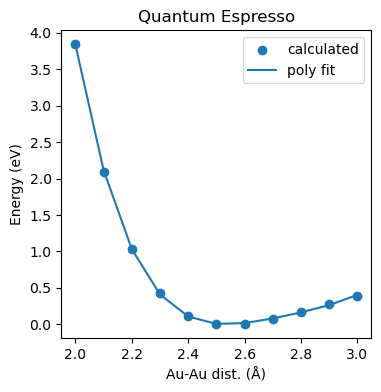

In [9]:
plt.figure(figsize=(4,4))

plt.scatter(d, qe_energy-qe_eopt, label='calculated')
plt.plot(d, np.polyval(poly, d)-qe_eopt, label='poly fit')

plt.xlabel('Au-Au dist. (Å)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Quantum Espresso')
plt.show()

## 2. SIESTA

In [10]:
# import the SIESTA calculator
os.environ['ASE_SIESTA_COMMAND'] = 'mpirun -np 4 /home/ceresoli/Codes/siesta-4.1.5/siesta <PREFIX.fdf >PREFIX.out'
os.environ['SIESTA_PP_PATH'] = './'

from ase.calculators.siesta import Siesta
from ase.units import Ry

siesta = Siesta(label='AuWIRE', xc='PBE', mesh_cutoff=200*Ry,
                energy_shift=0.01*Ry, basis_set='DZP', kpts=[5, 1, 1],
                fdf_arguments={'DM.MixingWeight': 0.1, 'MaxSCFIterations': 100})

In [11]:
# let's stretch the wire and compute the potential energy as a function of strain
# for this purpose we'll use numpy.linspace, fit to a polynomial, then plot the result with matplotlib
d = np.linspace(2.0, 3.0, 11)
siesta_energy = np.zeros_like(d)

for i in range(len(d)):
    wire = make_wire(spacing=d[i])
    wire.calc = siesta
    siesta_energy[i] = wire.get_potential_energy()
    print(d[i], siesta_energy[i])

Job completed


2.0 -899.953448


Job completed


2.1 -901.874818


Job completed


2.2 -903.066762


Job completed


2.3 -903.753021


Job completed


2.4 -904.101306


Job completed


2.5 -904.22938


Job completed


2.6 -904.219012


Job completed


2.7 -904.125668


Job completed


2.8 -903.989154


Job completed


2.9 -903.844584
3.0 -903.698981


Job completed


In [12]:
# fit polynominal, calculate first derivative, find the zero
poly = np.polyfit(d, siesta_energy, deg=4)
dpoly = np.polyder(poly, 1)

dopt = 0.0
for root in np.roots(dpoly):
    if abs(root.imag) < 1e-10 and 2.0 < root.real < 3.0:
        dopt = root.real
        
print(f'optimal d = {dopt:.4} Å')
siesta_eopt = np.polyval(poly, dopt)

optimal d = 2.526 Å


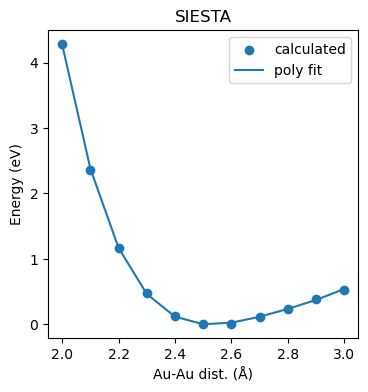

In [13]:
plt.figure(figsize=(4,4))

plt.scatter(d, siesta_energy-siesta_eopt, label='calculated')
plt.plot(d, np.polyval(poly, d)-siesta_eopt, label='poly fit')

plt.xlabel('Au-Au dist. (Å)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('SIESTA')
plt.show()

Let's redo the EMT calculation and compare with DFT calculations:

In [14]:
from ase.calculators.emt import EMT
d = np.linspace(2.0, 3.0, 11)
energy = np.zeros_like(d)

for i in range(len(d)):
    wire = make_wire(spacing=d[i])
    wire.calc = EMT()
    energy[i] = wire.get_potential_energy()
    
poly = np.polyfit(d, energy, deg=4)
dpoly = np.polyder(poly, 1)

dopt = 0.0
for root in np.roots(dpoly):
    if abs(root.imag) < 1e-10 and 2.0 < root.real < 3.0:
        dopt = root.real
        
print(f'optimal d = {dopt:.4} Å')
eopt = np.polyval(poly, dopt)

optimal d = 2.464 Å


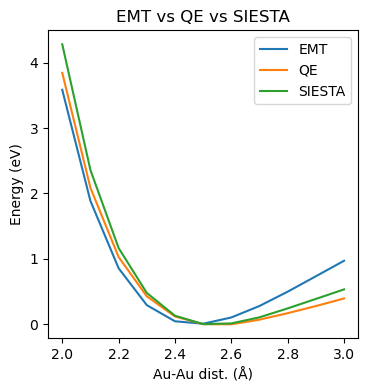

In [15]:
plt.figure(figsize=(4,4))

plt.plot(d, energy-eopt, label='EMT')
plt.plot(d, qe_energy-qe_eopt, label='QE')
plt.plot(d, siesta_energy-siesta_eopt, label='SIESTA')

plt.xlabel('Au-Au dist. (Å)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('EMT vs QE vs SIESTA')
plt.show()